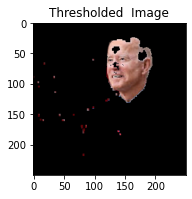

Color Bar
{'cluster_index': 0, 'color': [205.88763672522202, 158.06794829300776, 149.79980112694912], 'color_percentage': 0.5320309750087997}


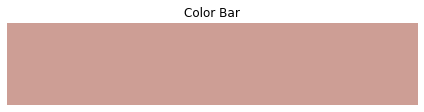

['dark' 'mild' 'mild' 'fair' 'dark' 'dark' 'mild' 'dark' 'mild' 'fair'
 'fair' 'dark' 'dark']
['fair']


C:\Users\91906\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [1]:
import os
os.sys.path
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt
import pandas as pd


def extractSkin(image):
    # Taking a copy of the image
    img = image.copy()
    # Converting from BGR Colours Space to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    
    #lower_threshold = np.array([0, 20, 20], dtype=np.uint8)        #test1
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)         #test2
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)
    #upper_threshold = np.array([15, 200, 200], dtype=np.uint8)
    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)


def removeBlack(estimator_labels, estimator_cluster):

    # Check for black
    hasBlack = False

    # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    def compare(x, y): return Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            # delete the occurance
            del occurance_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)


def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):

        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1]/totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation


def extractDominantColor(image, number_of_colors=2, hasThresholding=True):

    # Quick Fix Increase cluster counter to neglect the black
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation


def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0
    #or x in colorInformation:
    bottom_x = 1000    #top_x + (colorInformation[1]["color_percentage"] * color_bar.shape[1])
    #print('-----')
    #print(bottom_x)
    #print('------')
    print(colorInformation[0])
    for colour in colorInformation[0]['color']:
        if int(colour)>40:
            color = tuple(map(int, (colorInformation[0]['color'])))
            cv2.rectangle(color_bar, (int(top_x), -1),(int(bottom_x), color_bar.shape[0]), color, -10)
        #top_x = bottom_x
    return color_bar


def prety_print_data(color_info):
    for x in color_info:
        print(pprint.pformat(x))
        print()



#The below lines of code, is the implementation of the above defined function.

#UPLOADED IMAGE TO BE ATTACHED HERE!!

image = imutils.url_to_image('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcShdoO5S2LD9S4ahHL92vQ2GdPubniTgvsbDA&usqp=CAU')
#image = imutils.url_to_image('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVEhUSFBUYGBgZGBkaGRgZGBgYGBgYGBoaGhgaGhgcIS4lHB4rHxkYJzgmKy8xNTU1GiQ7QDs0Py40NTEBDAwMEA8QGhISGjQhISE0NDQ0NDE0NDQ0NDQ0NDQ0NDQ0NDQ0NDQxNDQ0NDE0NDQ0NDQ0NDQ0NDQ0NDQ0NDQxNP/AABEIAKgBLAMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAEAAIDBQYBBwj/xAA6EAACAQIEAwcCBAUEAgMAAAABAgADEQQSITEFQVETImFxgZGhsfAGBzLRFELB4fFSYnKCI7JDc6L/xAAYAQADAQEAAAAAAAAAAAAAAAAAAQIDBP/EACIRAQEBAQEAAwABBQEAAAAAAAABAhESAyExQRMiMlFhBP/aAAwDAQACEQMRAD8A2ojhIA8cHnI1TARwEgDxweATAToWRq8kVoB1lgeIWGkwPEmHCZ/iVSwMyeKxZzTU8VGhmOxSd4zXGYy1TxjTHjGmCBIPi8UlMXY68gN5p5iPVWNXiOUb68h98plMdi2eoS7NuRucvkByEjr4wsS305DkI1qufKDfT7tKzmRZlByX1Yix338paVqxFPMdSosra3sdxruNb/ZlXiKvjsdpPg8SLFbE35Wvv/WVKAoued9bw7A1bNYnQe8BCH+UHbUdLHWF01t+pbZv068wN7wCX+KL1C5OxIFtBYH+0N4qAwVwNXTvW3zKSLkeRHtBKyjuIQBfUMP9OxHgdveMVQ1MAue6xAYXN7jp6XjCA5EYXXOLciQbeI6/E3P4c/Fifoqs2W3dZluwtawOUai3Pw53mPCNa+TOvOzai/O3KRPhWzWUkeBtv7ydZmpyjr3LBVEqIHRgynYjaE9nPNfy94ulF3o1HIDkWvsrjTXpcaegnqE49483ipUQpxwpyQCOUSTR9nJaaR1pKgjkByU4QqTiiTKJpIDOziySW0VpXDRZJ3LJLRWj4EeWLLH2itAkdorSS05aAUApTopQkJHBIeYfQwpTopQnJFlh4HUK049UkgEeoi8DqJkgWJWWZWCYlNIeS6yvE+cyeJTvGa/iqbzK4ogEljYDcmaYjLVDNYC5NrdZkuLVs9RyDoCAPIQnieMLuSpOUGw5C3X1gZpqNWbcaAC+295YzniFKd7TmYX10H7SZjpp9iRqvO20S0iYYN3jp0HUxzf+PMQdQQABfUaX8v7TqOS19b9OQHQDzky4TMb6/vKHA9BFIztfUm52Gt/mQVXYsAdpaPgzYA3Hh5+UYuH5H0639PKAdCAqouTrexPzIsfVIGUaXsT0uOnjCHwrCxGx20PrIKlAnS5va9z5HSMuIsFiyh0N76eFvESzqIrrnBA281PQkbi+3OUIuDYj9oZgsXkYHa55bGEoo5EDEk3DjwNyRrp6X87T1v8ADvH6WIpoFcZ8oupIuSBqR1nleIVSLHQ2zKw3Nje19Nbj58Y3A4oo+cd2opD2Atmy/wAw8d9tDrJ3iahde5CSLK7g3EVxFFKybMNR/pYbj0MskE4+cvFpAJIgnAIrxwhKGSqYEHj1qzSKG3igorToqxgTFB+1i7WMCIoP2sXawAiKQdpOdrABJ2Q5jOZjL4acmcvIC5nC5j4XBIMkQQIVDCqDx8TUxWC4hYZB64isDLcXXeec/ismyi9gSb+g0vPSeMjeeSfiPGZ6roDoug6X5xRP7VTobdBE9xYbc9ekZhweXLnyklMZmJ3tKVD6dK9jrD6GFJuOsIweHuJcYegBaZa3xtn4+qynw60PoYImWaUbw6lRke7Wv9ORUNw02PPy8pDRwQ/mXnsOXkOc1FLD35Q+lgxbb70mubaz1iMLxXBuw2up2IGhF+np8yidGF76C1p6XjeG32NvixPS2nrMzj+FWvceQH13mlrPyx2JQHlz3G/tIKVP+U68wYbjqdiQBt9/WA5ttdb2EEWLCuCqpdja7baGxC29b/Qw7hpzKoezFTdToGt/NY8j+0Aw1QVFNNx3hqu4OnQ+X0keDOSpoba2tf5jJ6F+XOMdatTCsO5lLoeQIsNPMH4npFMTxThvE3o4ylXUHJdQ1hupsHHtf4857bSnP8uf7uiH2jGk1pFUEjhh3e0HfE2j66yqxKma5z1N1weMZ4xwxfjKXK053pp4L0vBi/Gd/i/GUWZpzO0PA9L/APix1i/ix1mfNRpztWh4Hpov4sdZz+MHWZ01mkXbvF4Hpr7RERAxQbGkRpEeROGAMAhVAQaFUJSaJkFeESCtEl51+Y+LZKICm2dwrG9iFysdD4kATyh9QSNxrPTPzSp3SkQRcOdL73U6jyt8zzOp+oW6Wighy6qV6i4/pD+G0QRA211t3lHuDLfhS9yTu8jTE7VjQSwh1AQNDLDDJOXVdmIssNTllRS0EwiSwpzTNPUSpYQhHkKyZKc1yz0ktfeVvEKAt6cv2lsqwDiq90y79RnzrzLjyBXbpf2/fl7zP1h/4wNze+nK/WaDj6kMb+h/aUD1A1wRZtNfpDN7GW5yieH1VOW+hB39tfrFjEAqa6aD0+9TIKCGwbo2tumxh+LpZtRuFB2vcXYaeOgl/wAMxGFDim2U5gNV19COdv7T2v8ACnEGxGDpVXFnK2cf7kJUn1Iv6zwzhWh7pOUghlPMeFptPwXx98PWFBzmpO4UHpm2YdDtcSN59QPWbSNxJhGOJhBQNYSvrLLOqIDWE3wjQQpGlJOVjSs16lD2YjSghGWNZYAMac52cmKxZYBD2YkXZCGWkeSHQuleOzQYGPDTDrr4mJnCYzNOFodLyfeFUDAM0Nw5lxOoMEhrSYSs47j0w+HqV3vlRcxA3PIAeJJA9YM68l/MbiNOriVpo+bsgyvbUByRpfmRbXptMMt7hed5O2oJG5N7nUm/M+Mhpt38x5QNJiDoGG1rev8AiX/CrCmCxsJm8Qll0OhNx+01eAwammmbXQTP5Pxr8X6KouhOhlrhk2lUcDSP6bg/7bn6RYcshIDnyOv+Jz6zP4dWdX+Y1eGYaQtWF5Q4LFX0lqGNrye8bclWArourEAdTBK3H6K7NfyH7zO8RdmNrm3TYQbDZA36Cx8rj3M2xpjv9bLC8dRzbKbeG8k4nXR0uh8xsRKzD4lEALoyDrluvqVuB6wrEqrLdT5EfHmJd39Izn7YT8QJdW95k3flbXkZuOO0NGmIQLms2mv3eV8d+mXzTlEYNbl0Ol7/ADsYUr3OQ6HJoeh70DRyrZzbfL4WhzurPkOmdND0Y3Uj4+ZrGCsoZ0aw0Kn3mh4fiXUpUsCVcGx2dR3h6gr8nwlSyXXfUnQ8xpqD7QjAVDlZXOXKVIPiGt8gkf8AaBV9F4eoHRXX9LKGXyYXH1nXEh4UyGhSyEMnZoFI2ICgD6Qhpz8MJUECqrD6gglQTTKaHKThSTZZwrNC4hySN0hNoxxAuBis5aPYRsZEFjMslEjvADFEkAnVWPAmDsMtGNJWkTRGZeHYYyvMOwplRnpYCUv4too+BxK1DZOxckgXK5VLAgcyCAfSXSyu46yDDVjUF07N846rkOYe15bKvnJbdmMoIfvFjfQjTKAPDX3kSWLa+B9pIosptuOV778o1dnI1NvbrA3HQ3KHqLeN5pMRWyU1v0HlKDDgNWpgeZ9BpNYcMHAzbTL5NSWdb/Hm3N4Y+GxNI0md0RXFwy5XIHT9QUnbTMN94cHzUs7uj6kDLZKosQM2TMQVvfmNpBTwCaDLoNhfT2hbtlXKNug0Ei6zWmfj1PvoPCVsr2BuNCPWbGgganfwmMw6XcTdcOo3p+gmckum87MsrxklDoCSel/k8htKyvRU0u0OIKuHQGmqMtkN72LC7HbXx2M13EeEFtYCnCCDofcf1m3+P5GOs3X8gOEvVOc0sS6gA5EdO1LHXTVVAG+pIt8S64XhKpW7qigm9kvlud7D+Xy2k+C4eQdfgWl7RogACHqa/RnNz+VkPxDhgFnm2IQio6gD9p65+I6YyGeTY9bVXI2sLjnbn8R4/wArE/PP7ZXcOiuGT2J6/wCYzD1lJGbkRY+X+J3B2DeY+sdgbNemdCw0v15GbRyU/EoFLAHc51/7HT5v7SWjiFem2YC62zD/AFKDqPfX3g2I7xJB/QAt/I7+5MJwdNHBtoxUgi+jXG3gfHxjN7J+WdQnBlC1wlQhNQSEKIwuOVyWPrNY08m/LSo6Y4ILlHQq3hkQMM3iCtv+xnrTzLU5QFqQV4VVgjmPKa5ORXivLJwyN5ITInMYQvIzHvGGOJdBjLx9oy0AP7SOV4Bnne0Mnw6PQ5nkbPBDUMidzF4E0MzQ/CyjRzLnBtpH54nVWazPfjrFdnw/EtzNNkHm/cv/APqaFZh/zWruuCCKO69RFc9FszD3ZAPWJNeLC4DHx+J2mSLsPExPcKCOQIIncMcoBbZjb94zEcOy/wAQrDYg++k2VIWmED5Ky9Fb67/X4m3wdUMoM5vmn26vgv0NUSGuukKpgQfFsDoducyjpofBpd9JvuDr3PSYvhxQPv00/wAzU0OLUqSX1tbU3H2BDNk19jlufpYYlgINYGVY47hqzEqzEnS63K389jCaOZRea3SZn6HILSXtNJXtiZE+KsJN1DmQnHqvcbynleMb/wAhYc2sfj95vuNYm6MZ562rkb5rnysbS/h+7aw/9N+pD2GVrjp9JLSpkFaq7L+rwA1B+JGXzUm6j6R+Cdksd1IAI8+RE6XIiIsS42YW9eenlH4anmK5DY/HhOVFyK/MZrdbEMf6Tp7pRl0B+xAPSfyzDHHVCR/8Bv4HPTHvcPPUXmJ/K4o1KsVXvh1DtrqMgZR4WJf3m2eZa/UhKxldVfWH4gyrrNrKyVSB528HDR4aWXUhaMcxXnGgDGkckMaYdIoy86TGXgZuUx4Uw8YaONCV6jRXhY11h7UoNVpxzQ4GSXGBlSqay4wIi1UrNZ5X+c3EGDYfDq/ds7uoOt7hULDp+u3r0nqqzxX82sOox4cOCz0kLLzUrdRfwIAPvM1MRWFtb8tRHUXAQZhdb+oPIyOoQdz/ALTHo2XcZlsNIANitWJvfneaLhmKORW6jXzlDiqYsGXYj7EL4NW3Xpr7yPkz2Nfi1zTY0K5MVd+UEw1SwjVxKdplZrHp1M55l1ev9iaC6hRp/SW+CASoFLXHx6wShQWwLZgCL6qQPDUiWGESgLE3vexNr8+Q26R+Tml9SwdNwpKgkbcgPJRpCKwCjXaViY3JoASv/FlIHjoQJHjuNgIzZXAUakocoHi1rAecv6kLqasBqRKjFPvBcJxO+YD9J1G+x85Fiq0ys+2nVbxvEWpmZnCLoWO3L785Y8bqlu4PsStFS1InxAHj92E6fhnI4/n128Nc2XJzOp6eUI4a1iqMNxp7/wCIEiXA17258/vSH0awCObC6WsehLAfY52mkYIq1Oxene5LFrX5AX+pkuBoM+HqVFKDsApZWPebO4Rco63POBd5m7Rd81z4Db4lggQ9oASGYDKAbAOrKxJ6jQi3+7wjD1b8o2U4eqQe+XXMvPLbuk9bnMP+s3TzAflXhL9riM2hRaZX/ffOx/8AX3ab+pMtfqQGIMqMQ2stsTKevvKymmho8PIRHAyyTB4s0iBnbwM8mMJnLxpMA4zyPPOvI4E0oE6RHxGJsHcSCqBCakFqGBdDZdZZYQQC0sMIYytWKzxH816YXiDMpuzU0LD/AEkXAt6Ae89sDTwP8d44VuJ4h1vZGVLf/WLH5zRGzdcXBFtSAfOdwzEmw3zDf784qidDe3vGYe4zP0gD8a4KggW1II6GC4arkcN92hGN5kbN3vI8/pA77RcPrX4KsGAtzhZVcyPYZlYMptsym4PuAfSZXhmLytlJ05ftNEla6/e857PNdObNR6RwjjdJ1VcRSytlKl0Fl37pyjwmkp4nB5Ea6aEctTp/MPnWeXcM4uoAV9D15GXuG4igA238+R6R+v8Ai/GbP2xua/GaCk5VzMy27oFudgSbTP8AH6pdL1yBcWyLouXpvudRfpeVNb8QIgsgF/n06SpxOKeoczR3ckE+OS/SDGEZiRzlPjMTa5heOrWBvM1jsRc29TIzPVPevMRGpmZ77lTb2gVRO4BeyruerbCFVaeuYH9a29r3g5ZeyYHkw8951ScnHDb29SOgALjkBp521j8UvcJGz5SfPn8/WTUls45oy2P37e0ixSEoqX1DEk+W8fAkoU8j790pf1FwZLw6xbtNirD1BIA+R8mDqM+XKdcp06gbev6jNB+GOGLXxVKgdLkZ/wDit2Yedr28bQS9c/A/Bf4bBopILOe0Yi9u8BlUX6KB63l7Uki2AsNANAPASGo0y/QAxEqa41ltiDKqrvLyVRWitH2itKIy0VpJactAGWjSJLaNMAhZZFaEOIy0A0nZmLszC8s7kg0AtRMhfDyzyThSCVScMYRh6ZEMZIlSLo44Np8/fjQAcSxWWw74Ittcqt/m5PnPoDEOVRmVcxAJCjdiBoNes+bMW2aq7hSuZ3JUkMykknKT1Bv7QOBaoNyRyte3zJcOTqQL+HpISCO9bbeOwzG/d3B08R0gaKsT+ofpIt5dBB3XnDMSO8y2sDsOhOsEzWNjAGX2lzw3H8jv9fGU5GpESmTrPpedXNbjBZWGstsNgkO6iYjhvESP1e80OH4rtrOfWbK6s6lalMJTXUKB5CRYmqoGko34zpvKrH8XLCy+/KKS1d3Mw7i2NF7DrKcISxvzGvgJBmYuGJvY69IRVAOg3cAeXX4nRjPI4/k36qMPYqw1ANvCcWiGqZb6EkgfOvTmJIi2DoNcux+byVFCqjf8iRzJsLfWaMyz5EsRezmw6hcwt9JFhltaob3Nxbne/wAc5L2eoqMTcPa3jrYDxv8ASdZwtwTc3vpsLf3JjSkROzIO5A18yNB7A+09N/AHDkpB+I13RAyBULsqi1lzPdjpcgjx+vmCPpdtdza+hv1j2xJY3Jv/AE8hyhZ2cD2fHfj7CIbJnqnqi2X3cgnzAMr1/MOmT3sNXA6qA/xpPL6de20Lo4s9YTGQ9ZwXG6GJB7J7sBdkYFXXzQ628do1zrPPsHxEgqTupup2ZT1VtxNngMaKiXvqN+XraPzz8RRl528izRZoF1LeK8jzRZoh0+84TGFpwtAdJjGXido3NAdba0VoopLZ207aKKIGssbliigFfx7FGjha9VWRWRHZS98mYDu3tyvafOLuWZnO7XY6W7zNdtOUUUZRAXs1uup8p2kAFQ+JvfxMUUDdrki63uLXUnoSLQVxck9IooAxtgedzEvQxRQB+GOtpYITaKKZaa5/D1BMbWW2mpP3rORQn6NfhU3sCLbAmOewCN5kgbki3952KaxkVIfrVt2XUdL8vaOvbI5Nzl7o8Tt/mKKMEzZVNzc7+A018TqfWDO5J1+zFFHSie3KPQRRQNMslRooo4kTSqS34fxF0IZQGtyOhI8Dt7xRS4VbPh+NSsmdCd7Mp0ZW6MOR+sJymKKZ1nXcpiymKKM3MpnCpnIoA1kMblMUUA//2Q==')
#image = cv2.imread('img_1.jpg')


# Resize image to a width of 250
image = imutils.resize(image, width=250)


img_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
img_YCrCb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

# Show image
plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
#plt.show()

# Apply Skin Mask
skin = extractSkin(image)
image_skin = cv2.cvtColor(skin, cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 1)
plt.imshow(image_skin)
plt.title("Thresholded  Image")
plt.show()

# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
dominantColors = extractDominantColor(skin, hasThresholding=True)
#print(dominantColors)
# Show in the dominant color information
#print("Color Information")
#prety_print_data(dominantColors)
# Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.axis("off")
plt.imshow(colour_bar)
plt.title("Color Bar")
plt.tight_layout()
plt.show()
'''
# aggregate skin pixels
blue = []
green = []
red = []

height, width, channels = image_skin.shape

for i in range (height):
    for j in range (width):
        if((img_HSV.item(i, j, 0) <= 170) and (140 <= img_YCrCb.item(i, j, 1) <= 170) and (90 <= img_YCrCb.item(i, j, 2) <= 120)):
            blue.append(image_skin[i, j].item(0))
            green.append(image_skin[i, j].item(1))
            red.append(image_skin[i, j].item(2))
        else:
            image_skin[i, j] = [0, 0, 0]
 

# determine mean skin tone estimate
skin_tone_estimate_BGR = [np.mean(blue), np.mean(green), np.mean(red)]
#print ("mean skin tone estimate (BGR)", skin_tone_estimate_BGR[0], skin_tone_estimate_BGR[1], skin_tone_estimate_BGR[2], "]")'''


#implementing KNN model
skin_tone_df = pd.read_csv('skin_tone_data.csv')
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

#le = LabelEncoder()
#skin_tone_df['skin_tone'] = le.fit_transform(skin_tone_df['skin_tone'])
X_train = skin_tone_df[['R','G','B']].values
Y_train = skin_tone_df[['skin_tone']].values
Y_train = Y_train.flatten()
print(Y_train)
X_test = np.array([[dominantColors[0]['color'][0],dominantColors[0]['color'][1],dominantColors[0]['color'][2]]])
#print(X_train,Y_train)
#X_test = np.array([[ skin_tone_estimate_BGR[0],skin_tone_estimate_BGR[1],skin_tone_estimate_BGR[2]]])
#print(X_test)
model = LogisticRegression()
model.fit(X_train,Y_train)   #Training the model with pre-made data

#PREDICTED RESULT HERE
predicted_tone = model.predict(X_test)
print(predicted_tone)